## Import all necessary libraries

In [1]:
from PIL import Image
import numpy as np
import pickle
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, GRU,Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten, BatchNormalization, Masking

from keras.layers.core import Dropout
from keras.layers.wrappers import Bidirectional
from keras.preprocessing import image
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D

Using TensorFlow backend.


## InceptionV3 Model for Keras

    This is the standard InceptionV3 model and weights we are using are pretrained.
    GoogLeNet InceptionV3 Architecture for Image feature extraction takes a pre-processed image of dimensions 299*299 and encodes the image to generate 2048 feature for further processing.

In [2]:
from __future__ import print_function
from __future__ import absolute_import

import warnings

from keras.models import Model
from keras import layers
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.engine.topology import get_source_inputs
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import _obtain_input_shape


WEIGHTS_PATH = 'inception_v3_weights_tf.h5'
WEIGHTS_PATH_NO_TOP = 'inception_v3_weights_tf_notop.h5'


def conv2d_bn(x,
              filters,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1),
              name=None):
    """Utility function to apply conv + BN.

    # Arguments
        x: input tensor.
        filters: filters in `Conv2D`.
        num_row: height of the convolution kernel.
        num_col: width of the convolution kernel.
        padding: padding mode in `Conv2D`.
        strides: strides in `Conv2D`.
        name: name of the ops; will become `name + '_conv'`
            for the convolution and `name + '_bn'` for the
            batch norm layer.

    # Returns
        Output tensor after applying `Conv2D` and `BatchNormalization`.
    """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    if K.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
    x = Conv2D(
        filters, (num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=False,
        name=conv_name)(x)
    x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    x = Activation('relu', name=name)(x)
    return x


def InceptionV3(include_top=True,
                weights='imagenet',
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000):
    """Instantiates the Inception v3 architecture.

    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    Note that the default input image size for this model is 299x299.

    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(299, 299, 3)` (with `channels_last` data format)
            or `(3, 299, 299)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 139.
            E.g. `(150, 150, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.

    # Returns
        A Keras model instance.

    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(
        input_shape,
        default_size=299,
        min_size=139,
        data_format=K.image_data_format(),
        include_top=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3

    x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
    x = conv2d_bn(x, 32, 3, 3, padding='valid')
    x = conv2d_bn(x, 64, 3, 3)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv2d_bn(x, 80, 1, 1, padding='valid')
    x = conv2d_bn(x, 192, 3, 3, padding='valid')
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # mixed 0, 1, 2: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed0')

    # mixed 1: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed1')

    # mixed 2: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed2')

    # mixed 3: 17 x 17 x 768
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(
        branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate(
        [branch3x3, branch3x3dbl, branch_pool], axis=channel_axis, name='mixed3')

    # mixed 4: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed4')

    # mixed 5, 6: 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch7x7, branch7x7dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(5 + i))

    # mixed 7: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 192, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed7')

    # mixed 8: 8 x 8 x 1280
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,
                          strides=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(
        branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate(
        [branch3x3, branch7x7x3, branch_pool], axis=channel_axis, name='mixed8')

    # mixed 9: 8 x 8 x 2048
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = layers.concatenate(
            [branch3x3_1, branch3x3_2], axis=channel_axis, name='mixed9_' + str(i))

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = layers.concatenate(
            [branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch3x3, branch3x3dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(9 + i))
    if include_top:
        # Classification block
        x = GlobalAveragePooling2D(name='avg_pool')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='inception_v3')

    # load weights
    if weights == 'imagenet':
        if K.image_data_format() == 'channels_first':
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
        if include_top:
            weights_path = WEIGHTS_PATH
        else:
            weights_path = WEIGHTS_PATH_NO_TOP
            
        model.load_weights(weights_path)
    return model

#### Loading the model

In [3]:
model = InceptionV3(weights='imagenet')

In [4]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [5]:
model_new.trainable = False
for i in model_new.layers:
    i.trainable = False

## Image Preprocessing functions

In [6]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc


##### Loading unique word dictionary, word to index and index to word mappings and setting a few values  

In [8]:
unique = pickle.load(open('unique.p', 'rb'))
word2idx = pickle.load(open('word2idx_final.p', 'rb'))
idx2word = pickle.load(open('idx2word_final.p', 'rb'))

In [9]:
max_len = 40
vocab_size = len(unique)

## Our model

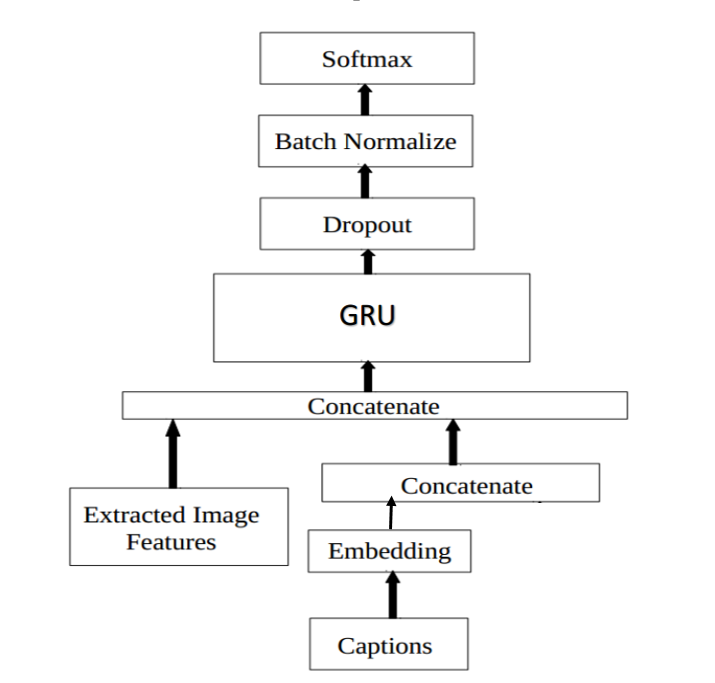

In [10]:
embedding_size = 300

image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(1)
    ])

caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        GRU(256, return_sequences=True),
        TimeDistributed(Dense(300)),
        ])

### Merging the models and creating a softmax classifier

In [11]:
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(GRU(256, return_sequences=False)),
        Dropout(0.25),
        Dense(vocab_size),
        BatchNormalization(),
        Activation('softmax')
    ])

G:\WinPython-64bit-3.5.3.1Qt5\python-3.5.3.amd64\lib\site-packages\ipykernel\__main__.py:2: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  from ipykernel import kernelapp as app


In [12]:
final_model.load_weights('inceptionv3_adam_128-GRU256.hdf5')

#### Now you can store your pictures in this directory (../Image-Captioning/Flickr8k/) and predict as shown below

### Predict Function to Predict any image

    This is a greedy method where we iteratively output the word that would appear next and eventually build a caption. The test image is encoded and passed to the prediction function and an array of words is predicted and the word with the highest probability is selected using the numpy argmax() function and the process continues until <end> is reached.


In [28]:
def predict_captions(image):
    start_word = ["<start>"]
    e = encode(image)
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

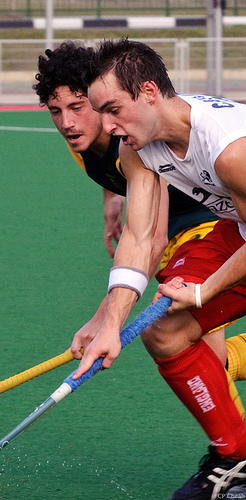

In [49]:
try_image = 'test02.jpg'
Image.open(try_image)

In [50]:
print ('Normal Max search:', predict_captions(try_image)) 

Normal Max search: Two men playing a game on a sports field .


### Beam Search Prediction
    
    The Beam Search algorithm considers the set of ‘k’ best sentences(k being the beam size) and keeps track of resulting ‘k’ of the candidates and build up sentences so that it can end up with the overall most probable caption. By having choice of words we can overcome the repetition problem that occurs while using the Argmax Method


In [22]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    e = encode(image)
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [51]:
print ('Normal Max search:', beam_search_predictions(try_image)) 

Normal Max search: Two men are playing rugby .
